In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import json
import spacy
from pathlib import Path
from spacy.training import Example
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import wikipedia
import os
from pyvis.network import Network

import networkx as nx

import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

os.chdir(r'C:\Users\Final_Project\Labelling_Outputs\Training_Datasets')

nlp = spacy.load("en_core_web_lg") # load other spacy model
ner = nlp.get_pipe("ner")
ner.add_label("DRUG")  # Add the "DRUG" label
ner.add_label("GANG_ORG")  # Add the "GANG_ORG" label

1

In [37]:
ruler = nlp.add_pipe("entity_ruler")

In [38]:
with open(r'C:\Users\Final_Project\patterns\drugs_patterns.jsonl', encoding='utf-8') as f:
    drugs_patterns = []
    for line in f:
        drugs_patterns.append(json.loads(line))

In [39]:
ruler.add_patterns(drugs_patterns)

In [40]:
with open(r'C:\Users\Final_Project\patterns\gang_patterns.jsonl', encoding='utf-8') as f:
    gang_patterns = []
    for line in f:
        gang_patterns.append(json.loads(line))

In [41]:
ruler.add_patterns(gang_patterns)

In [42]:
doc = nlp("The US government has described the Sinaloa Cartel as one of the largest drug-trafficking organisations in the world")
print([(ent.text, ent.label_) for ent in doc.ents])

[('US', 'GPE'), ('the Sinaloa Cartel', 'ORG')]


In [43]:
def convert_to_spacy_format(json_data):
    training_data = []
    for item in json_data:
        text = item["text"]
        entities = [(label["start"], label["end"], label["labels"][0]) for label in item["label"]]
        example = Example.from_dict(nlp.make_doc(text), {"entities": entities})
        training_data.append(example)
    return training_data

In [44]:
with open('Training_Dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [85]:
data

[{'text': "The Chicago Outfit (also known as the Outfit, the Chicago Mafia, the Chicago Mob, the Chicago crime family, the South Side Gang or The Organization) is an Italian-American organized crime syndicate or crime family based in Chicago, Illinois, which originated in the city's South Side in 1910.",
  'id': 163,
  'label': [{'start': 0,
    'end': 18,
    'text': 'The Chicago Outfit',
    'labels': ['ORG']},
   {'start': 38, 'end': 44, 'text': 'Outfit', 'labels': ['ORG']},
   {'start': 46, 'end': 63, 'text': 'the Chicago Mafia', 'labels': ['ORG']},
   {'start': 65, 'end': 80, 'text': 'the Chicago Mob', 'labels': ['ORG']},
   {'start': 86, 'end': 93, 'text': 'Chicago', 'labels': ['GPE']},
   {'start': 108,
    'end': 147,
    'text': 'the South Side Gang or The Organization',
    'labels': ['ORG']},
   {'start': 155, 'end': 162, 'text': 'Italian', 'labels': ['NORP']},
   {'start': 223, 'end': 230, 'text': 'Chicago', 'labels': ['GPE']},
   {'start': 232, 'end': 240, 'text': 'Illinoi

In [45]:
training_data = convert_to_spacy_format(data)

In [87]:
training_data

[{'doc_annotation': {'cats': {}, 'entities': ['B-ORG', 'I-ORG', 'L-ORG', 'O', 'O', 'O', 'O', 'O', 'U-ORG', 'O', 'B-ORG', 'I-ORG', 'L-ORG', 'O', 'B-ORG', 'I-ORG', 'L-ORG', 'O', 'O', 'U-GPE', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'L-ORG', 'O', 'O', 'O', 'U-NORP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'U-GPE', 'O', 'U-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'L-LOC', 'O', 'U-DATE', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['The', 'Chicago', 'Outfit', '(', 'also', 'known', 'as', 'the', 'Outfit', ',', 'the', 'Chicago', 'Mafia', ',', 'the', 'Chicago', 'Mob', ',', 'the', 'Chicago', 'crime', 'family', ',', 'the', 'South', 'Side', 'Gang', 'or', 'The', 'Organization', ')', 'is', 'an', 'Italian', '-', 'American', 'organized', 'crime', 'syndicate', 'or', 'crime', 'family', 'based', 'in', 'Chicago', ',', 'Illinois', ',', 'which', 'originated', 'in', 'the', 'city', "'s", 'South', 'Side', 'in', '1910', '.'], 'SPACY': [True, True

In [46]:
import pandas as pd
import os
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin


In [48]:
optimizer = nlp.resume_training()
move_names = list(ner.move_names)

In [49]:
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [59]:
import random
with nlp.disable_pipes(*unaffected_pipes):
    for iteration in range(30):
        from spacy.util import minibatch, compounding
# shuffling examples  before every iteration
        random.shuffle(training_data)
        losses = {}
# batch up the examples using spaCy's minibatch
        batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))

        for batch in batches:
            nlp.update(
            batch,  # batch of examples
            drop=0.5,  # dropout - make it harder to memorize data
            losses=losses,
    )

        print("Losses", losses)

Losses {'ner': 70.50875262990957}
Losses {'ner': 78.61788789666942}
Losses {'ner': 104.14859255378073}
Losses {'ner': 126.39469141001719}
Losses {'ner': 89.88891096490032}
Losses {'ner': 82.86855069328014}
Losses {'ner': 89.9497936482646}
Losses {'ner': 80.2767975901094}
Losses {'ner': 115.51570818966253}
Losses {'ner': 78.64659310352647}
Losses {'ner': 84.11048914813915}
Losses {'ner': 126.91317174991548}
Losses {'ner': 89.05348427716085}
Losses {'ner': 81.46431058631624}
Losses {'ner': 109.60087361064755}
Losses {'ner': 81.39835038887873}
Losses {'ner': 90.70830285580209}
Losses {'ner': 80.71187828003704}
Losses {'ner': 106.03409726861311}
Losses {'ner': 99.71460074853249}
Losses {'ner': 98.5963563080988}
Losses {'ner': 100.79835666945846}
Losses {'ner': 89.67427677783807}
Losses {'ner': 89.73418025302911}
Losses {'ner': 73.79278887556755}
Losses {'ner': 82.82434633714536}
Losses {'ner': 109.0760103764161}
Losses {'ner': 103.92613238913395}
Losses {'ner': 75.20532182442497}
Losses {'

In [68]:
# Testing the model
doc = nlp("The Sinaloa Federation has also formed alliances with two powerful Chinese Triads, Sun Yee On and the 14K Triad, to acquire the precursor chemicals needed in creating highly-addictive synthetic drugs like methamphetamine, and now, likely fentanyl. Operatives like local gangs pick up the chemicals from dropoff points and ship them to hidden labs. The resulting products are shipped to the United States and many South American countries.[185] The Sinaloa Cartel also reportedly has a major presence in Colombia and has partnered with various paramilitary drug cartels such as the Clan del Golfo")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('Sinaloa Federation', 'GANG_ORG'), ('two', 'CARDINAL'), ('Chinese Triads', 'GANG_ORG'), ('Sun Yee', 'GANG_ORG'), ('14K Triad', 'GANG_ORG'), ('methamphetamine', 'DRUG'), ('fentanyl', 'DRUG'), ('the United States', 'GPE'), ('South American', 'NORP'), ('Sinaloa Cartel', 'GANG_ORG'), ('Colombia', 'GPE'), ('Clan del Golfo', 'GANG_ORG')]


In [71]:
#Testing the model with uploading text, that model did't see earlier 
import pathlib
doc = nlp(pathlib.Path('Test.txt').read_text(encoding="utf-8"))
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('Jalisco New Generation Cartel', 'GANG_ORG'), ('Spanish', 'NORP'), ('Cártel de Jalisco Nueva Generación', 'GANG_ORG'), ('CJNG', 'ORG'), ('Los Mata Zetas,[44][45][46][47', 'GANG_ORG'), ('Mexican', 'NORP'), ('Jalisco', 'GPE'), ('Nemesio Oseguera Cervantes', 'PERSON'), ('El Mencho', 'PERSON'), ('one', 'CARDINAL'), ('CJNG', 'ORG'), ('cocaine', 'DRUG'), ('methamphetamine', 'DRUG'), ('2020', 'DATE'), ('CJNG', 'ORG'), ('Mexican', 'NORP'), ('Mexico[29', 'CARDINAL'), ('second', 'ORDINAL'), ('Sinaloa Cartel.[51] CJNG', 'GANG_ORG'), ('CJNG', 'ORG'), ('Jalisco', 'GPE'), ('Nayarit', 'GPE'), ('Colima', 'GPE'), ('South American', 'NORP'), ('cocaine', 'DRUG'), ('Zetas', 'GANG_ORG'), ('La Resistencia', 'GANG_ORG'), ('Aguililla', 'GPE'), ('Michoacán', 'GPE'), ('territories.[37][30][55', 'DRUG'), ('CJNG', 'ORG'), ('Sinaloa Cartel', 'GANG_ORG'), ('Chiapas', 'GPE'), ('Zacatecas', 'GPE'), ('Jalisco New Generation Cartel', 'GANG_ORG'), ('Milenio Cartel', 'GANG_ORG'), ('La Resistencia', 'GANG_ORG')

In [62]:
print("Entities", doc.ents)

Entities (the Aryan Brotherhood of Texas, the Aryan Brotherhood (AB, California, the 1960s, 1981, Texan, Aryan Brotherhood, Texas, Texas, ABT, the 1980s, Texas, Hispanic, Texas, Aryan Society, the Aryan Brothers, the early to mid-1980s, two, the Aryan Brotherhood of Texas, Aryan Circle)


In [72]:
# Count occurrences of each kind of entity
entity_counts = {}

for ent in doc.ents:
    entity_label = ent.label_
    if entity_label not in entity_counts:
        entity_counts[entity_label] = 1
    else:
        entity_counts[entity_label] += 1
        
# Print the entity counts
for label, count in entity_counts.items():
    print(f"{label}: {count}")

GANG_ORG: 174
NORP: 30
ORG: 149
GPE: 254
PERSON: 160
CARDINAL: 100
DRUG: 11
DATE: 144
ORDINAL: 11
MONEY: 4
FAC: 3
LOC: 6
TIME: 3
QUANTITY: 7
EVENT: 1


In [64]:
# Output directory
from pathlib import Path
output_dir=Path(r'C:\Users\Final_Project\content')

# Saving the model to the output directory
if not output_dir.exists():
  output_dir.mkdir()
nlp.meta['name'] = 'my_ner'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to C:\Users\Oles\ML\From The Frontline\Final_Project\content


In [65]:
# Loading the model from the directory
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
assert nlp2.get_pipe("ner").move_names == move_names

Loading from C:\Users\Oles\ML\From The Frontline\Final_Project\content


In [66]:
doc2 = nlp2(pathlib.Path('Test22.txt').read_text(encoding="utf-8"))
print("Entities", [(ent.text, ent.label_) for ent in doc2.ents])

Entities [('The Five Families', 'GANG_ORG'), ('five', 'CARDINAL'), ('New York City', 'GPE'), ('1931', 'DATE'), ('Salvatore Maranzano', 'PERSON'), ('Castellammarese War', 'GANG_ORG'), ('Maranzano', 'PERSON'), ('Italian American', 'NORP'), ('New York City', 'GPE'), ('Maranzano', 'PERSON'), ('Profaci', 'PERSON'), ('Mangano', 'PERSON'), ('Luciano', 'PERSON'), ('Gagliano', 'PERSON'), ('Bonanno', 'PERSON'), ('Colombo', 'PERSON'), ('Gambino', 'PERSON'), ('Genovese', 'PERSON'), ('Lucchese', 'PERSON'), ('Maranzano', 'PERSON'), ('September', 'DATE'), ('Lucky Luciano', 'PERSON'), ('Mafia', 'GANG_ORG'), ('the United States', 'GPE'), ('the Five Families', 'GANG_ORG'), ('the Chicago Outfit', 'GANG_ORG'), ('1963', 'DATE'), ('Joseph Valachi', 'PERSON'), ('New York City', 'GPE'), ('Five Families', 'GANG_ORG'), ('Valachi', 'GPE'), ('the Five Families', 'GANG_ORG'), ('Sixth Family', 'GANG_ORG'), ('the Five Families', 'GANG_ORG'), ('the 1920s', 'DATE'), ('Mafia', 'GANG_ORG'), ('U.S.', 'GPE'), ('Giuseppe',

In [67]:
# Count occurrences of each kind of entity
entity_counts = {}

for ent in doc2.ents:
    entity_label = ent.label_
    if entity_label not in entity_counts:
        entity_counts[entity_label] = 1
    else:
        entity_counts[entity_label] += 1
        
# Print the entity counts
for label, count in entity_counts.items():
    print(f"{label}: {count}")

GANG_ORG: 40
CARDINAL: 7
GPE: 29
DATE: 17
PERSON: 111
NORP: 11
EVENT: 1
ORDINAL: 2
ORG: 2
LOC: 1
FAC: 2


In [221]:
print([(ent.text, ent.label_) for ent in doc.ents])

[('Five Families', 'GANG_ORG'), ('American Mafia', 'GANG_ORG'), ('Salvatore Maranzano', 'PERSON'), ('Castellammarese War', 'GANG_ORG'), ('Colombo', 'LOC'), ('Lucky Luciano', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Chicago Outfit', 'GANG_ORG'), ('Joseph Valachi', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Sixth Family', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Joe The Boss" Masseria', 'PERSON'), ('Campania', 'LOC'), ('Southern Italy', 'LOC'), ('Charles "Lucky" Luciano', 'PERSON'), ('Albert "Mad Hatter', 'PERSON'), ('Vito Genovese', 'PERSON'), ('Alfred Mineo', 'PERSON'), ('Willie Moretti', 'PERSON'), ('Joe Adonis', 'PERSON'), ('Frank Costello', 'PERSON'), ('Don Vito Cascio Ferro', 'PERSON'), ('Castellammare del Golfo', 'LOC'), ('Salvatore Maranzano', 'PERSON'), ('Joseph "Joe Bananas', 'PERSON'), ('Joseph Profaci', 'PERSON'), ('Masseria', 'DRUG'), ('Masseria', 'LOC'), ('Masseria', 'DRUG'), ('Joe Adonis', 'PERSON'), ('Adonis', 'DRUG'), ('Adonis', 'D

In [177]:
#Printing all text contents of labels and labels itself
print([(ent.text, ent.label_) for ent in doc.ents])

[('Five Families', 'GANG_ORG'), ('Italian American Mafia', 'GANG_ORG'), ('Salvatore Maranzano', 'PERSON'), ('Castellammarese War', 'GANG_ORG'), ('Italian American', 'GANG_ORG'), ('Colombo', 'LOC'), ('Lucky Luciano', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Chicago Outfit', 'GANG_ORG'), ('Joseph Valachi', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Sixth Family', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Giuseppe "Joe The Boss', 'PERSON'), ('Campania', 'LOC'), ('Southern Italy', 'LOC'), ('Charles "Lucky" Luciano', 'PERSON'), ('Albert "Mad Hatter', 'PERSON'), ('Vito Genovese', 'PERSON'), ('Alfred Mineo', 'PERSON'), ('Willie Moretti', 'PERSON'), ('Joe Adonis', 'PERSON'), ('Frank Costello', 'PERSON'), ('Don Vito Cascio Ferro', 'PERSON'), ('Salvatore Maranzano', 'PERSON'), ('Joseph "Joe Bananas', 'PERSON'), ('Joseph Profaci', 'PERSON'), ('Castellammarese War', 'GANG_ORG'), ('Joe Adonis', 'PERSON'), ('Coney Island', 'LOC'), ('Brooklyn', 'LOC'), ('Benjami

In [178]:
#Printing all text contents of labels
print([(ent.text) for ent in doc.ents])

['Five Families', 'Italian American Mafia', 'Salvatore Maranzano', 'Castellammarese War', 'Italian American', 'Colombo', 'Lucky Luciano', 'Five Families', 'Chicago Outfit', 'Joseph Valachi', 'Five Families', 'Five Families', 'Sixth Family', 'Five Families', 'Giuseppe "Joe The Boss', 'Campania', 'Southern Italy', 'Charles "Lucky" Luciano', 'Albert "Mad Hatter', 'Vito Genovese', 'Alfred Mineo', 'Willie Moretti', 'Joe Adonis', 'Frank Costello', 'Don Vito Cascio Ferro', 'Salvatore Maranzano', 'Joseph "Joe Bananas', 'Joseph Profaci', 'Castellammarese War', 'Joe Adonis', 'Coney Island', 'Brooklyn', 'Benjamin "Bugsy', 'Italian American', 'Five Families', 'Wappingers Falls', 'di tutti', 'Vincent "Mad Dog', '230 Park Avenue', 'Manhattan', 'Meyer Lansky', 'di tutti', 'Five Families', 'Charlie "Lucky" Luciano', 'Vincent Mangano', 'Tommy Gagliano', 'Joseph Bonanno', 'Joe Profaci', 'Chicago Outfit', 'Al Capone', 'Charlie Luciano', 'five Mafia', 'RICO', 'RICO', 'Five Families', 'Joseph Valachi', 'Fi

In [56]:
print(doc.ents)

(American Mafia, Salvatore Maranzano, Colombo, Gambino, Lucky Luciano, Five Families, Chicago Outfit, Joseph Valachi, Five Families, Five Families, Sixth Family, Five Families, Joe The Boss, Campania, Vito Genovese, Alfred Mineo, Willie Moretti, Joe Adonis, Frank Costello, Don Vito Cascio Ferro, Castellammare del Golfo, Salvatore Maranzano, Joseph "Joe Bananas, Joseph Profaci, Castellammarese War, Masseria, Joe Adonis, Coney Island, Brooklyn, Five Families, Mangano, Wappingers Falls, Vincent "Mad Dog, Manhattan, Meyer Lansky, Five Families, Vincent Mangano, Tommy Gagliano, Joseph Bonanno, Joe Profaci, Chicago Outfit, Al Capone, Charlie Luciano, five Mafia, Five Families, Joseph Valachi, Five Families, Five Families, Charles Luciano, Tommaso Gagliano, Joseph Profaci, Salvatore Maranzano, Vincent Mangano, Five Families, Tommy Lucchese, Vito Genovese, Joseph Colombo, Carlo Gambino, Joe Bonanno, Five Families)


In [49]:
#splitting test text into sentences
sentences = [sent.text.strip() for sent in doc.sents]

In [47]:
#Testing the model with uploading text, that model did't see earlier 
import pathlib
doc = nlp(pathlib.Path('Test.txt').read_text(encoding="utf-8"))
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('American Mafia', 'GANG_ORG'), ('Salvatore Maranzano', 'PERSON'), ('Colombo', 'LOC'), ('Gambino', 'LOC'), ('Lucky Luciano', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Chicago Outfit', 'GANG_ORG'), ('Joseph Valachi', 'PERSON'), ('Five Families', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Sixth Family', 'GANG_ORG'), ('Five Families', 'GANG_ORG'), ('Joe The Boss', 'PERSON'), ('Campania', 'LOC'), ('Vito Genovese', 'PERSON'), ('Alfred Mineo', 'PERSON'), ('Willie Moretti', 'PERSON'), ('Joe Adonis', 'PERSON'), ('Frank Costello', 'PERSON'), ('Don Vito Cascio Ferro', 'PERSON'), ('Castellammare del Golfo', 'LOC'), ('Salvatore Maranzano', 'PERSON'), ('Joseph "Joe Bananas', 'PERSON'), ('Joseph Profaci', 'PERSON'), ('Castellammarese War', 'GANG_ORG'), ('Masseria', 'LOC'), ('Joe Adonis', 'PERSON'), ('Coney Island', 'LOC'), ('Brooklyn', 'LOC'), ('Five Families', 'GANG_ORG'), ('Mangano', 'LOC'), ('Wappingers Falls', 'PERSON'), ('Vincent "Mad Dog', 'PERSON'), ('Manhattan', 'LOC'), ('Meye

In [50]:
sentences[1]

'In 1931, the five families were organized by Salvatore Maranzano following his victory in the Castellammarese War.'

In [138]:
type(doc)

spacy.tokens.doc.Doc

In [169]:
#Extracting nouns from test text
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])

Nouns: ['crime', 'family', 'family', 'victory', 'gang', 'family', 'family', 'family', 'territory', 'hierarchy', 'entity', 'family', 'boss', 'boss', 'boss', 'assassination', 'role', 'committee', 'activity', 'conflict', 'family', 'boss', 'boss', 'crime', 'family', 'existence', 'hearing', 'crime', 'family', 'level', 'designation', 'history', 'operation', 'faction', 'gangster', 'region', 'faction', 'hatter', 'mafioso', 'bid', 'control', 'operations.[1', 'base', 'control', 'faction', 'faction', 'leadership', 'follower', 'force', 'conflict', 'guard', 'leadership', 'mustache', 'world', 'way', 'business', '-', 'group', 'thinking', 'non', '-', 'approach', 'follower', 'prosper', 'time', 'aim', 'group', 'war', 'order', 'business', 'conflict', 'objective', 'mob', 'orthodox', 'vision', 'follower', 'inadequacy', 'leadership', 'faction', 'mobster', 'side', 'ally', 'tension', 'faction', 'side', 'alcohol', 'truck', 'alcohol', 'production', 'prohibition', 'decision', 'war', 'opportunity', 'allegiance', 

In [225]:
#Extracting noun phrases from test text
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])

Noun phrases: ['The Five Families', 'five Italian American Mafia crime families', 'that', 'New York City', 'the five families', 'Salvatore Maranzano', 'his victory', 'the Castellammarese War', 'Maranzano', 'the Italian American gangs', 'New York City', 'the Maranzano', 'Profaci', 'Mangano', 'Luciano', 'Gagliano families', 'which', 'the Bonanno', 'Colombo', 'Gambino', 'Genovese', 'Lucchese families', 'Each family', 'a demarcated territory', 'an organizationally structured hierarchy', 'the same overarching governing entity', 'Maranzano', "each family's boss", 'him', 'the capo dei capi', '("boss', 'all the bosses', 'this', 'his assassination', 'that role', 'The Commission', 'a ruling committee', 'Lucky Luciano', 'all Mafia activities', 'the United States', 'conflicts', 'families', 'It', 'the bosses', 'the Five Families', 'the bosses', 'the Chicago Outfit', 'the Buffalo crime family', 'Joseph Valachi', 'the existence', "New York City's Five Families", 'the Valachi hearings', 'a few other c

In [51]:
#Get Relations for the entities
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [52]:
#example for getting relations for the entities in the sentence
get_relation(sentences[3])

'had'

In [53]:
# Count the number of entities in each sentence
entity_counts_per_sentence = []
for sent in sentences:
    # Create a SpaCy Doc object for each sentence
    sent_doc = nlp(sent)
    
    # Count the number of entities in the sentence
    entity_count = len(sent_doc.ents)
    
    # Get the names of entities in the sentence
    entity_names = [ent.text for ent in sent_doc.ents]
    
    # Store the result
    entity_counts_per_sentence.append((sent, entity_count, entity_names))

# Print the results
for sent, count, names in entity_counts_per_sentence:
    print(f"Sentence: {sent}")
    print(f"Number of entities: {count}")
    print(f"Entity names: {names}")
    print(get_relation(sent))
    print("------")

Sentence: The Five Families refer to five Italian American Mafia crime families that operate in New York City.
Number of entities: 1
Entity names: ['American Mafia']
refer to
------
Sentence: In 1931, the five families were organized by Salvatore Maranzano following his victory in the Castellammarese War.
Number of entities: 1
Entity names: ['Salvatore Maranzano']
organized
------
Sentence: Maranzano reorganized the Italian American gangs in New York City into the Maranzano, Profaci, Mangano, Luciano, and Gagliano families, which are now known as the Bonanno, Colombo, Gambino, Genovese, and Lucchese families.
Number of entities: 2
Entity names: ['Colombo', 'Gambino']
reorganized
------
Sentence: Each family had a demarcated territory and an organizationally structured hierarchy and reported to the same overarching governing entity.
Number of entities: 0
Entity names: []
had
------
Sentence: Initially, Maranzano intended each family's boss to report to him as the capo dei capi ("boss of

In [54]:
# Create a DataFrame
entity_counts_per_sentence = []
for sent in sentences:
    sent_doc = nlp(sent)
    entity_count = len(sent_doc.ents)
    entity_names = [ent.text for ent in sent_doc.ents]
    relation = get_relation(sent)
    if entity_count >= 2:
        entity_counts_per_sentence.append((sent, entity_names[0], entity_names[1:], relation))

# Create a DataFrame
df = pd.DataFrame(entity_counts_per_sentence, columns=['Sentence', 'Source', 'Targets', 'Relation'])

In [55]:
df

,Sentence,Source,Targets,Relation
0,"Maranzano reorganized the Italian American gangs in New York City into the Maranzano, Profaci, Mangano, Luciano, and Gagliano families, which are now known as the Bonanno, Colombo, Gambino, Genove...",Colombo,[Gambino],reorganized
1,It consisted of the bosses of the Five Families as well as the bosses of the Chicago Outfit and the Buffalo crime family.,Five Families,[Chicago Outfit],consisted of
2,"In 1963, Joseph Valachi publicly disclosed the existence of New York City's Five Families at the Valachi hearings.",Joseph Valachi,[Five Families],disclosed
3,"Since then, a few other crime families have been able to become powerful or notable enough to rise to a level comparable to that of the Five Families, holding or sharing the unofficial designation...",Five Families,[Sixth Family],been
4,"History\nLeading up to the Five Families\nIn the 1920s, Mafia operations in the U.S. were controlled by Giuseppe ""Joe The Boss"" Masseria, whose faction consisted mainly of gangsters from Sicily an...",Five Families,"[Joe The Boss, Campania]",controlled
5,"Masseria's faction included Charles ""Lucky"" Luciano, Albert ""Mad Hatter"" Anastasia, Vito Genovese, Alfred Mineo, Willie Moretti, Joe Adonis, and Frank Costello.",Vito Genovese,"[Alfred Mineo, Willie Moretti, Joe Adonis, Frank Costello]",included
6,"However, powerful Sicilian mafioso Don Vito Cascio Ferro decided to make a bid for control of Mafia operations.[1] From his base in Castellammare del Golfo, he sent Salvatore Maranzano to seize co...",Don Vito Cascio Ferro,"[Castellammare del Golfo, Salvatore Maranzano]",decided
7,"The Castellammarese faction in the U.S. included Joseph ""Joe Bananas"" Bonanno, Stefano ""The Undertaker"" Magaddino, Joseph Profaci, and Joe Aiello.[2]","Joseph ""Joe Bananas",[Joseph Profaci],included
8,"On April 15, 1931, Masseria was killed at Nuova Villa Tammaro, a Coney Island restaurant in Brooklyn.",Coney Island,[Brooklyn],killed at
9,"With Maranzano's blessing, Luciano took over Masseria's gang and became Maranzano's lieutenant, ending the Castellammarese War.[8]\n\nThe Five Families' formation\nWith Masseria gone, Maranzano re...",Five Families,[Mangano],reorganized


In [234]:
# Assuming you already have a DataFrame df with columns 'Source', 'Targets', 'Edge'
kg_df = pd.DataFrame({'source': df['Source'], 'target': df['Targets'].apply(lambda x: x[0]), 'edge': df['Relation']})


In [235]:
print(edge_labels)

{('Five Families', 'Italian American Mafia'): 'refer to', ('Five Families', 'Chicago Outfit'): 'consist of', ('Five Families', 'Sixth Family'): 'been', ('Five Families', 'Giuseppe "Joe The Boss'): 'controlled', ('Five Families', 'Campania'): 'controlled', ('Five Families', 'Southern Italy'): 'controlled', ('Five Families', 'Charlie "Lucky" Luciano'): 'consist of', ('Five Families', 'Vincent Mangano'): 'were', ('Five Families', 'Tommy Gagliano'): 'consist of', ('Five Families', 'Joseph Bonanno'): 'consist of', ('Five Families', 'Joe Profaci'): 'consist of', ('Five Families', 'Al Capone'): 'consist of', ('Five Families', 'Joseph Valachi'): 'disclosed', ('Five Families', 'Five Families'): 'disclosed', ('Five Families', 'Charles Luciano'): 'were', ('Five Families', 'Tommaso Gagliano'): 'were', ('Five Families', 'Joseph Profaci'): 'were', ('Five Families', 'Salvatore Maranzano'): 'were', ('Five Families', 'Tommy Lucchese'): 'revealed', ('Five Families', 'Vito Genovese'): 'revealed', ('Five 

In [236]:
kg_df

,source,target,edge
0,Five Families,American Mafia,refer to
1,Salvatore Maranzano,Castellammarese War,organized
2,Five Families,Chicago Outfit,consisted of
3,Joseph Valachi,Five Families,disclosed
4,Five Families,Sixth Family,been
5,Five Families,"Joe The Boss"" Masseria",controlled
6,"Charles ""Lucky"" Luciano","Albert ""Mad Hatter",included
7,Don Vito Cascio Ferro,Castellammare del Golfo,decided
8,"Joseph ""Joe Bananas",Joseph Profaci,included
9,Joe Adonis,Adonis,joined


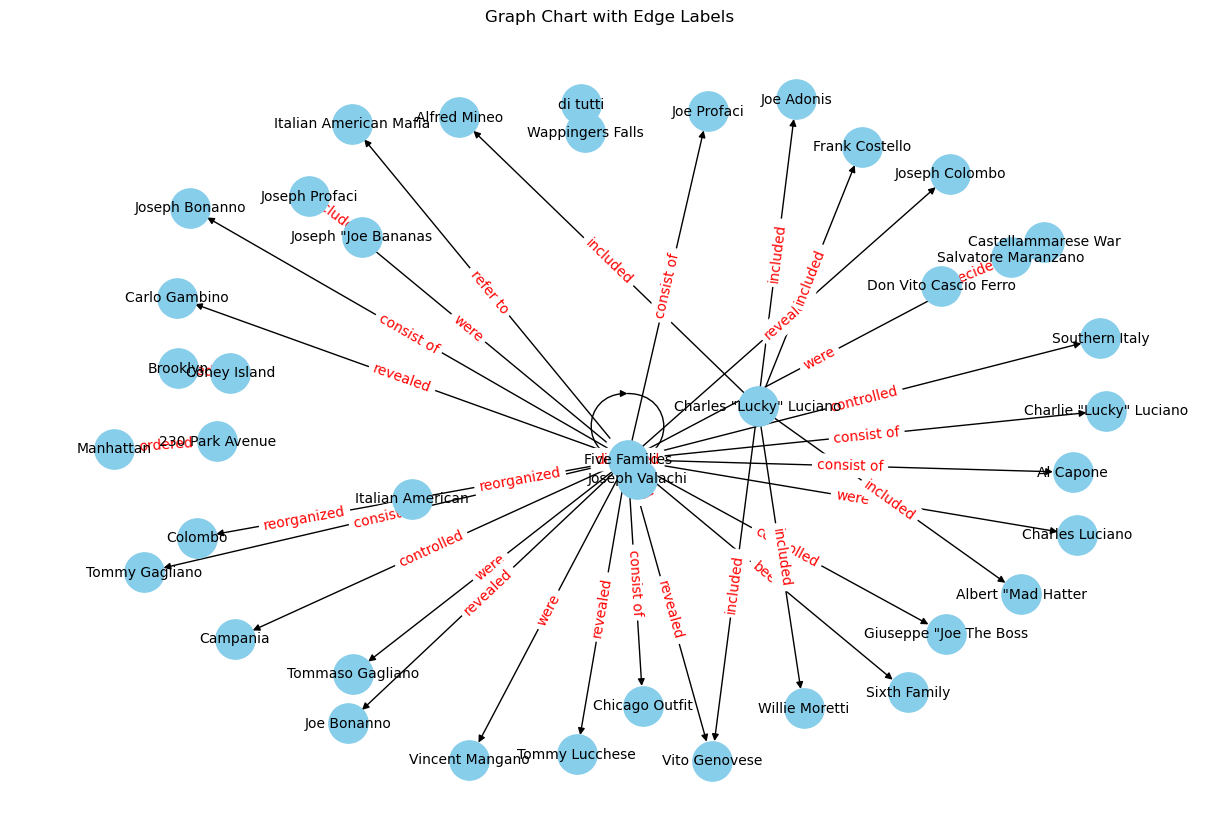

In [189]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    source = row['Source']
    targets = row['Targets']
    relation = row['Relation']

    # Add source and target nodes
    G.add_node(source)
    if isinstance(targets, list):
        G.add_nodes_from(targets)

    # Add edges with labels
    if isinstance(targets, list):
        for target in targets:
            G.add_edge(source, target, label=relation)

# Visualize the graph
pos = nx.spring_layout(G)
edge_labels = {(source, target): data['label'] for source, target, data in G.edges(data=True)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Graph Chart with Edge Labels")
plt.show()


In [196]:

from pyvis.network import Network
import pandas as pd

# Assuming df is your DataFrame
# Create a directed graph
G = Network(notebook=True, directed=True,
    heading="Network of Named Entities, detected by trained custom model")

# Add nodes and edges to the graph
for _, row in df.iterrows():
    source = row['Source']
    targets = row['Targets']
    relation = row['Relation']

    # Add source node
    G.add_node(source)

    # Add target nodes and edges with labels
    if isinstance(targets, list):
        for target in targets:
            G.add_node(target, color='red')
            G.add_edge(source, target, label=relation, font_color="red")  # Use label for edge labels

            

# Visualize the graph
#G.show_buttons(filter_=['physics'])
G.show('graphy88.html')


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
